# Advanced preprocessing with tiling

In [2]:
using Pkg
Pkg.activate("../ift-notebooks")
using IceFloeTracker
using Images

  Activating project at `~/Documents/research/packages/IceFloeTracker.jl/notebooks/ift-notebooks`


In [3]:
# Sample input parameters expected by the main function
cloud_mask_settings = (
    prelim_threshold=110.0,
    band_7_threshold=200.0,
    band_2_threshold=190.0,
    ratio_lower=0.0,
    ratio_upper=0.75,
    use_uint8=true,
)

# Parameters used in various preprocessing functions
adapthisteq_params = (
    white_threshold=25.5, entropy_threshold=4, white_fraction_threshold=0.4
)

adjust_gamma_params = (gamma=1.5, gamma_factor=1.3, gamma_threshold=220)

structuring_elements = (
    se_disk1=collect(IceFloeTracker.MorphSE.StructuringElements.strel_diamond((3, 3))),
    se_disk2=IceFloeTracker.se_disk2(),
    se_disk4=IceFloeTracker.se_disk4(),
)

unsharp_mask_params = (radius=10, amount=2.0, factor=255.0)

brighten_factor = 0.1

ice_masks_params = (
    band_7_threshold=5,
    band_2_threshold=230,
    band_1_threshold=240,
    band_7_threshold_relaxed=10,
    band_1_threshold_relaxed=190,
    possible_ice_threshold=75,
    k=3, # number of clusters for kmeans segmentation
    factor=255, # normalization factor to convert images to uint8
)

prelim_icemask_params = (radius=10, amount=2, factor=0.5)

(radius = 10, amount = 2, factor = 0.5)

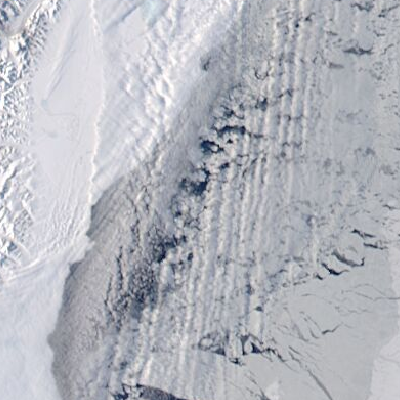

In [4]:
fc_image = RGB.(load("../notebook-example-images/049-beaufort_sea-100km-20160305.aqua.falsecolor.250m.tiff"))
tc_image = RGB.(load("../notebook-example-images/049-beaufort_sea-100km-20160305.aqua.truecolor.250m.tiff"))

## Landmask
TBD items:
* update the "create_landmask" function to have easier access to changing the structure element
* enforce the convention for 1 = land, 0 = ocean

In [62]:
lm = RGB.(load("../notebook-example-images/049-beaufort_sea-100km-20160305.aqua.landmask.250m.tiff"))
lm = IceFloeTracker.create_landmask(lm, se_dilation);

In [87]:
typeof(lm)

@NamedTuple{dilated::BitMatrix, non_dilated::BitMatrix}

## Cloud mask

In the tiling workflow, we export both the opaque cloud mask and the thin cloud mask. The mask interpretation is different than in the original algorithm. I would like to get the cloudmask creation to happen just in the create_cloudmask function, but allow options for different cloud mask algorithms. For example, we could have an option for "opaque_only=True" that reproduces the original cloud mask, and if false, returns the clouds view and the cloud_over_ice view.

TBD:
* update create_cloudmask to include options for the two different methods
* enforce the mask convention that 1=cloud, both for the thin clouds and for the opaque cloud mask
* change the language in the settings to focus on clouds, to prevent confusion with the ice labels section
* determine whether the `clouds_red` thing can happen inside the process tiles function using the `thin_cloud_mask`

In [63]:
mask_cloud_ice, clouds_view_init = IceFloeTracker._get_masks(
            float64.(fc_image); cloud_mask_settings...
        )

clouds_view = .!mask_cloud_ice .* clouds_view_init;

In [64]:
fc_img_cloudmasked = fc_image .* .!clouds_view

# Get clouds_red for adaptive histogram equalization
clouds_red = IceFloeTracker.to_uint8(float64.(red.(fc_img_cloudmasked) .* 255))
clouds_red[.!lm.dilated] .= 0;

## Tiling
Setting prelim sizes to the size of the original image works fine for getting the largest size. Will need to check later how sensitive the results are to this step.

TBD:
* Fix the error with +/- pixel happening instead of +/- tile.

In [65]:
# set up the tiling
prelim_sizes = size(tc_image) .÷ 6
tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1)

6×6 Matrix{Tuple{UnitRange{Int64}, UnitRange{Int64}}}:
 (1:67, 1:67)     (1:67, 68:134)     …  (1:67, 336:400)
 (68:134, 1:67)   (68:134, 68:134)      (68:134, 336:400)
 (135:201, 1:67)  (135:201, 68:134)     (135:201, 336:400)
 (202:268, 1:67)  (202:268, 68:134)     (202:268, 336:400)
 (269:335, 1:67)  (269:335, 68:134)     (269:335, 336:400)
 (336:400, 1:67)  (336:400, 68:134)  …  (336:400, 336:400)

In [66]:
prelim_sizes

(66, 66)

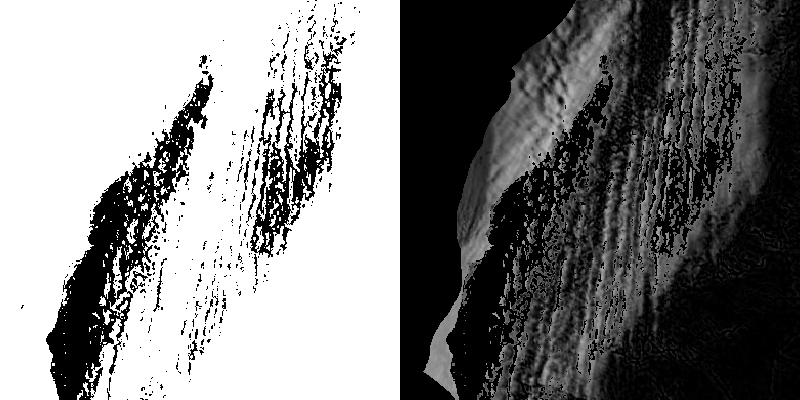

In [67]:
Images.mosaicview([.!clouds_view, Gray.(clouds_red ./ 255)], nrow=1)

## Process image tiles

```julia
function _process_image_tiles(
    true_color_image,
    clouds_red,
    tiles,
    white_threshold,
    entropy_threshold,
    white_fraction_threshold,
)

    # Apply diffuse (anisotropic diffusion) to each channel of true color image
    true_color_diffused = IceFloeTracker.diffusion(float64.(true_color_image), 0.1, 75, 3)

    rgbchannels = get_rgb_channels(true_color_diffused)

    # For each tile, compute the entropy in the false color tile, and the fraction of white and black pixels
    for tile in tiles
        clouds_tile = clouds_red[tile...]
        entropy = Images.entropy(clouds_tile)
        whitefraction = sum(clouds_tile .> white_threshold) / length(clouds_tile)

        # If the entropy is above a threshold, and the fraction of white pixels is above a threshold, then apply histogram equalization to the tiles of each channel of the true color image. Otherwise, keep the original tiles.
        if entropy > entropy_threshold && whitefraction > white_fraction_threshold
            for i in 1:3
                eqhist = adapthisteq(rgbchannels[:, :, i][tile...])
                @view(rgbchannels[:, :, i])[tile...] .= eqhist
            end
        end
    end

    return rgbchannels
end
```

The procedure is to first do the true color diffusion on the whole image, then to do the tile by tile adjustments. Each tile is checked for the entropy within band 2 (for only the pixels within the cloud mask), and the whitefraction is checked. The whitefraction is the percentage of pixels in the tile where the band 2 clouds are above a given threshold.

The adapthisteq function does the following:
 1. normalize using (I - min(I))/(max(I) - min(I))
 2. equalize_adapthist from sk_exposure
 3. rescale the image to the original range

TBD:
* Include the diffusion step as its own step in the preprocessing algorithm. Check its inputs and outputs, and allow the parameters to be adjusted. 
* Add the fc_image and cloud mask as an input, so that "clouds_red" is computed inside the function.
* Update so that it acts as a filter: image in, image out!

In [68]:
rgbchannels = IceFloeTracker._process_image_tiles(
    tc_image, clouds_red, tiles, adapthisteq_params...);
gammagreen = @view rgbchannels[:, :, 2];
equalized_gray = IceFloeTracker.rgb2gray(rgbchannels);

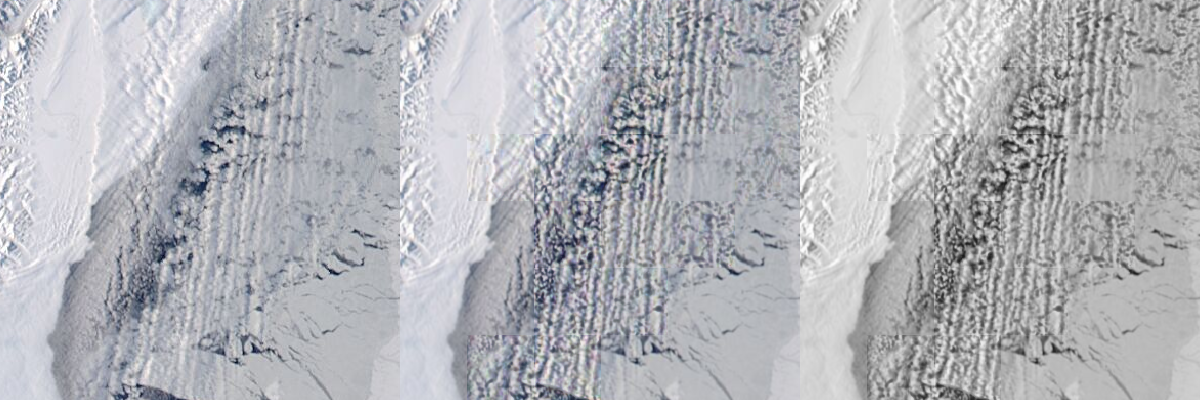

In [69]:
altered_tc_im = colorview(RGB, rgbchannels[:,:,1]/255, rgbchannels[:,:,2]/255, rgbchannels[:,:,3]/255)
Images.mosaicview([tc_image, altered_tc_im, Gray.(equalized_gray./255)], nrow=1)

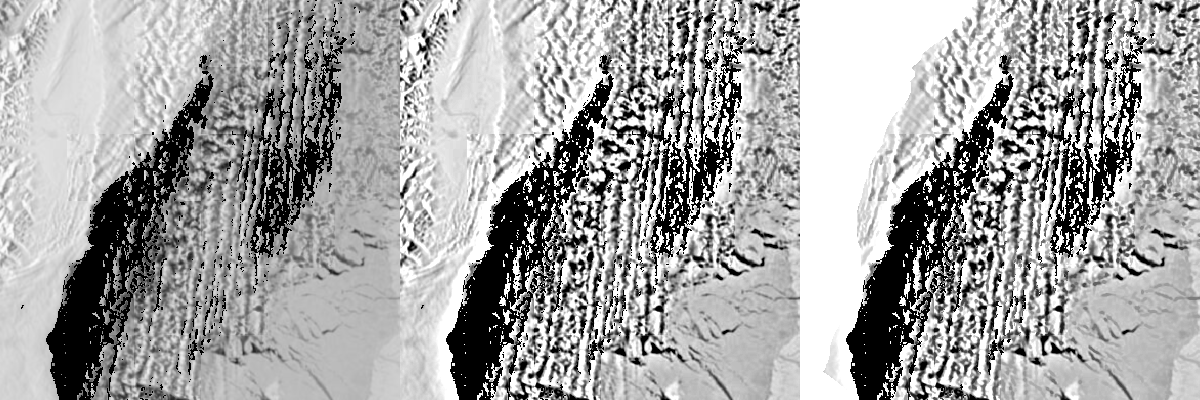

In [70]:
# question: how does this differ from a standard application of the cloud mask?
masks = [f.(fc_img_cloudmasked) .== 0 for f in [red, green, blue]]
combo_mask = reduce((a, b) -> a .& b, masks)
equalized_gray[combo_mask] .= 0;


sharpened = IceFloeTracker.to_uint8(IceFloeTracker.unsharp_mask(equalized_gray, unsharp_mask_params...))
equalized_gray_sharpened_reconstructed = IceFloeTracker.reconstruct(
    sharpened, structuring_elements.se_disk1, "dilation", true
)
equalized_gray_sharpened_reconstructed[.!lm.dilated] .= 0;
Images.mosaicview([Gray.(equalized_gray./255), Gray.(sharpened./255), 1 .- Gray.(equalized_gray_sharpened_reconstructed./255)], nrow=1)

In [71]:
# step 6
equalized_gray_reconstructed = deepcopy(equalized_gray)
equalized_gray_reconstructed[.!lm.dilated] .= 0
equalized_gray_reconstructed = IceFloeTracker.reconstruct(
    equalized_gray_reconstructed, structuring_elements.se_disk1, "dilation", true
)
equalized_gray_reconstructed[.!lm.dilated] .= 0;

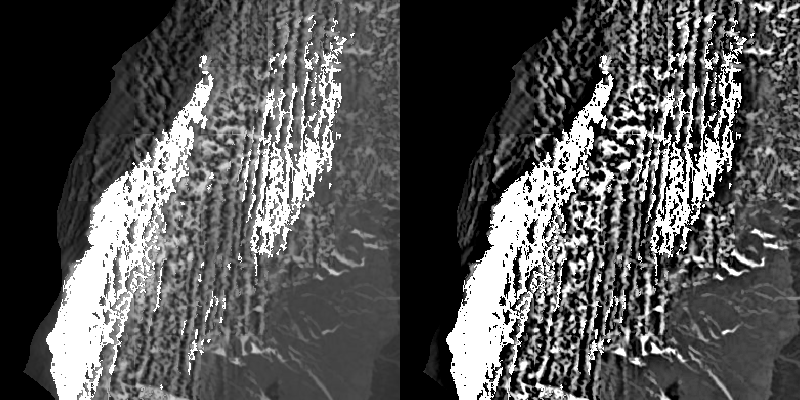

In [72]:
Images.mosaicview([Gray.(equalized_gray_reconstructed./255), Gray.(equalized_gray_sharpened_reconstructed./255)], nrow=1)

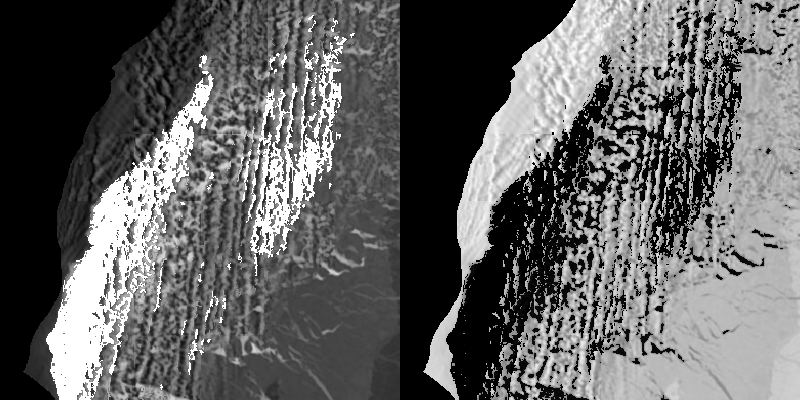

In [73]:
# step 7
brighten = IceFloeTracker.get_brighten_mask(equalized_gray_reconstructed, gammagreen)
equalized_gray[.!lm.dilated] .= 0
equalized_gray .= IceFloeTracker.imbrighten(equalized_gray, brighten, brighten_factor)
Images.mosaicview([Gray.(equalized_gray_reconstructed./255), Gray.(equalized_gray./255)], nrow=1)

In [74]:
# step 8
morphed_residue = clamp.(equalized_gray - equalized_gray_reconstructed, 0, 255)

equalized_gray_sharpened_reconstructed_adjusted = IceFloeTracker.imcomplement(
    IceFloeTracker.adjustgamma(equalized_gray_sharpened_reconstructed, adjust_gamma_params.gamma))
adjusting_mask = equalized_gray_sharpened_reconstructed_adjusted .> adjust_gamma_params.gamma_threshold
morphed_residue[adjusting_mask] .= IceFloeTracker.to_uint8.(morphed_residue[adjusting_mask] .* adjust_gamma_params.gamma_factor);

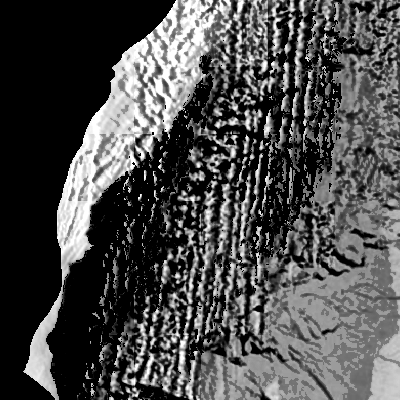

In [75]:
# morphed_residue is 1-d, so we reshape it to visualize
Images.mosaicview(Gray.(reshape(morphed_residue, size(equalized_gray))./255))

# Ice Masks
Looks to me like some of the issues with the tiling comes in to the get_ice_masks function moreso than the preprocessing stuff. Including the overlap with the dilated landmask. So we'll need to look closer at this one.

In [76]:
prelim_icemask, binarized_tiling = IceFloeTracker.get_ice_masks(
    fc_image, morphed_residue, .!lm.dilated, tiles, true; ice_masks_params...
)

(icemask = Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1], bin = Bool[0 0 … 0 0; 0 0 … 1 1; … ; 0 0 … 1 1; 0 0 … 1 1])

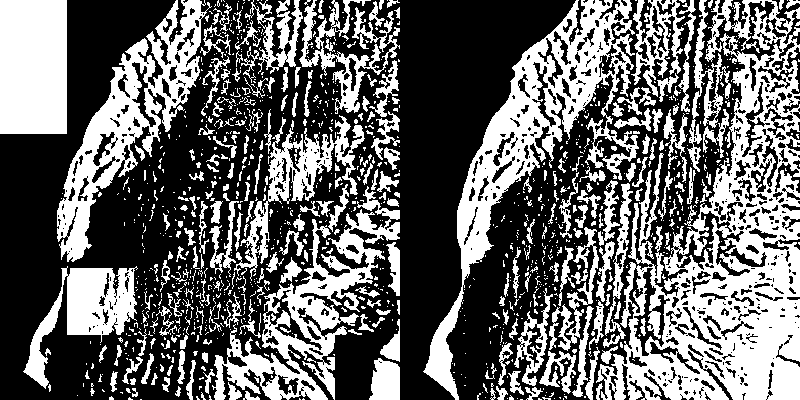

In [77]:
Images.mosaicview([Gray.(prelim_icemask), Gray.(binarized_tiling)], nrow=1)

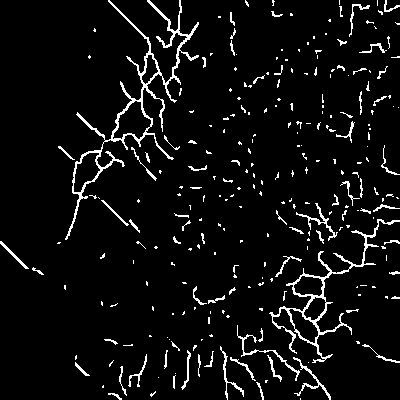

In [78]:
segment_mask = IceFloeTracker.get_segment_mask(prelim_icemask, binarized_tiling)
Images.mosaicview(Gray.(segment_mask))

In [79]:
local_maxima_mask, L0mask = IceFloeTracker.watershed2(
    morphed_residue, segment_mask, prelim_icemask
)

(fgm = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1], L0mask = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

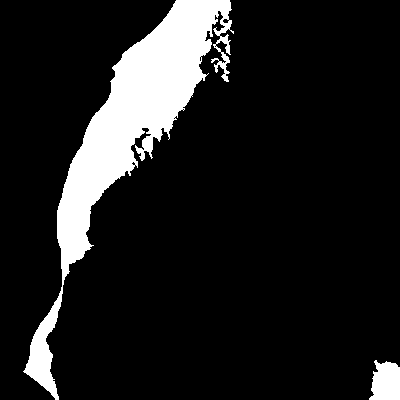

In [80]:
Images.mosaicview(Gray.(local_maxima_mask))

In [81]:
local_maxima_mask = IceFloeTracker.to_uint8(local_maxima_mask * 255)
prelim_icemask2 = IceFloeTracker._regularize(
    morphed_residue,
    local_maxima_mask,
    segment_mask,
    L0mask,
    structuring_elements.se_disk1;
    prelim_icemask_params...,
);

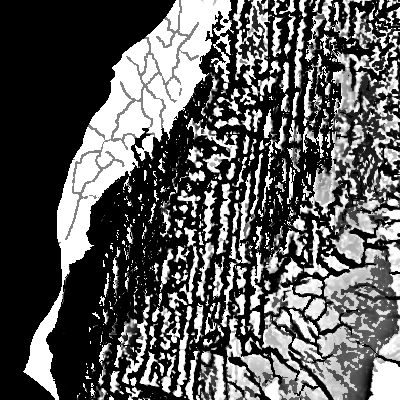

In [82]:
Images.mosaicview(Gray.(prelim_icemask2./maximum(prelim_icemask2)))

In [83]:
icemask, _ = IceFloeTracker.get_ice_masks(
    fc_image, prelim_icemask2, .!lm.dilated, tiles, false; ice_masks_params...
)

se_erosion = structuring_elements.se_disk1
se_dilation = structuring_elements.se_disk2
final = IceFloeTracker.get_final(icemask, segment_mask, se_erosion, se_dilation);

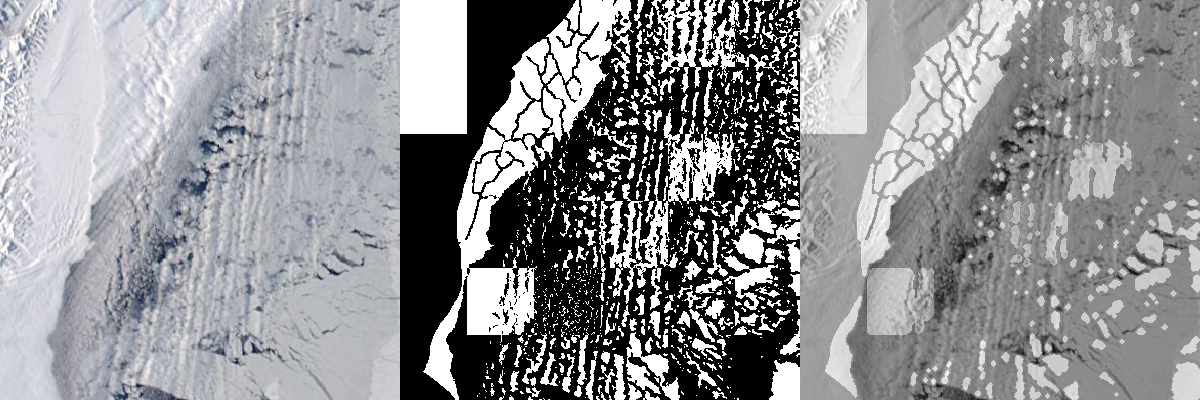

In [84]:
Images.mosaicview([tc_image, Gray.(icemask), 0.75.*Gray.(tc_image) .+ 0.25.*Gray.(final)], nrow=1)